In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

Lets have a quick look into the dataset

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print("Shape of training set : {}".format(train.shape))
print("Shape of test set : {}".format(test.shape))

Shape of training set : (7613, 5)
Shape of test set : (3263, 4)


In [7]:
### Lets check for the mssing values 
print("NO OF MISSING VALUES :");print("------Training set-------")
print("keyword : {}".format(train.keyword.isnull().sum()))
print("location : {}".format(train.location.isnull().sum()))
print("-------Test data--------")
print("keyword : {}".format(test.keyword.isnull().sum()))
print("location : {}".format(test.location.isnull().sum()))
print("");print("")
print("PROPORTION OF MISSING VALUES :");print("------Training set-------")
print("keyword : {}".format(train.keyword.isnull().sum()/train.shape[0]*100))
print("location : {}".format(train.location.isnull().sum()/train.shape[0]*100))
print("-------Test data--------")
print("keyword : {}".format(test.keyword.isnull().sum()/test.shape[0]*100))
print("location : {}".format(test.location.isnull().sum()/test.shape[0]*100))

NO OF MISSING VALUES :
------Training set-------
keyword : 61
location : 2533
-------Test data--------
keyword : 26
location : 1105


PROPORTION OF MISSING VALUES :
------Training set-------
keyword : 0.8012610009194797
location : 33.27203467752528
-------Test data--------
keyword : 0.796812749003984
location : 33.86454183266932


Proportion of missing values for both 'keyword','location' is roughly the same in both training & test data where
'keyword' : 0.8% in both train & test data
    'location' : 33% in both train & test data

In [8]:
### remove location
train.drop(columns=['location','keyword'],inplace=True)
test.drop(columns=['location','keyword'],inplace=True)

Text(0.5, 1.0, 'target distribution')

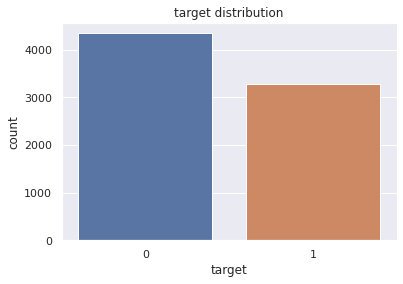

In [9]:
### class distribution of target###
sns.set(style='darkgrid', context='notebook')
sns.countplot(x='target', data=train).set_title('target distribution')
#plt.title('target distribution')

There lies a slight imbalance in the distribution of '0' & '1'

In [10]:
### lets take a quick look at some of the texts to guess what sort of cleaning needs to be done
for i in [5,12,44,22,45,67,99,122,455,78,2225,558,111,5578,546,447,944,6557,1115,447,6552,4177,700,4999,425]:
    print(train.text[i])
    print('\n')

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires


#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 


I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX


Love skiing


I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6


'I can't have kids cuz I got in a bicycle accident &amp; split my testicles. it's impossible for me to have kids' MICHAEL YOU ARE THE FATHER


only had a car for not even a week and got in a fucking car accident .. Mfs can't fucking drive .


That moment when you get on a scary roller coaster and the guy behind you is just screaming bloody murder ?????? #silverwood #aftershock


Ûª93 blasts accused Yeda Yakub dies in Karachi of heart attack http://t.co/mfKqyxd8XG #Mumbai


I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM


Whole slew of updated p

In [11]:
train.text[455]

'\x89Ûª93 blasts accused Yeda Yakub dies in Karachi of heart attack http://t.co/mfKqyxd8XG #Mumbai'

(-0.5, 399.5, 199.5, -0.5)

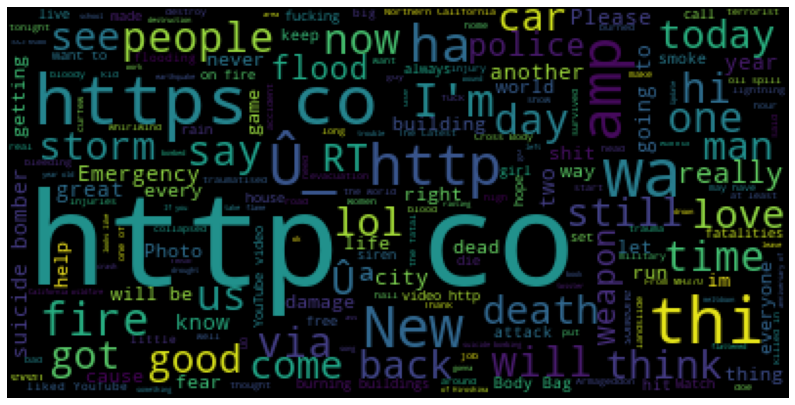

In [12]:
### Visualising through wordclouds 
texts = train.text.tolist()
texts_combined = ' '.join(texts)
plt.figure(figsize=(14,14))
plt.imshow(WordCloud().generate(texts_combined))
plt.axis("off")

**A lot of stopwords, https, needs to be cleaned !!**

Text(0.5, 1.0, 'positive texts')

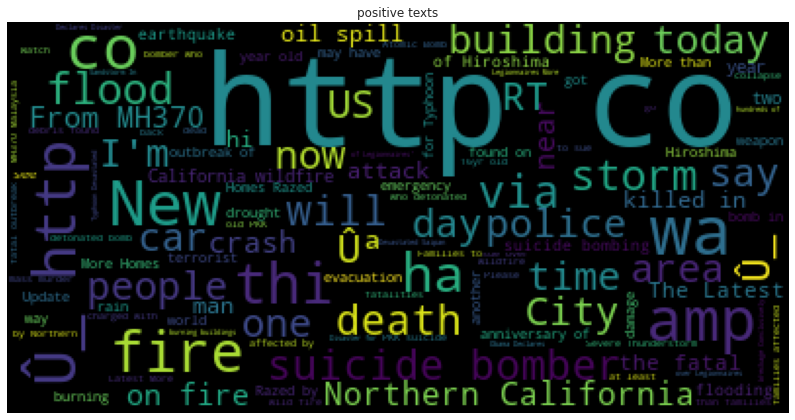

In [13]:
### Visualising for positive texts
positive = train.text[train.target == 1]
positive_texts = positive.tolist()
positive_texts_combined = ' '.join(positive_texts)
plt.figure(figsize=(14,14))
plt.imshow(WordCloud().generate(positive_texts_combined))
plt.axis("off")
plt.title("positive texts")

Text(0.5, 1.0, 'Negative targets')

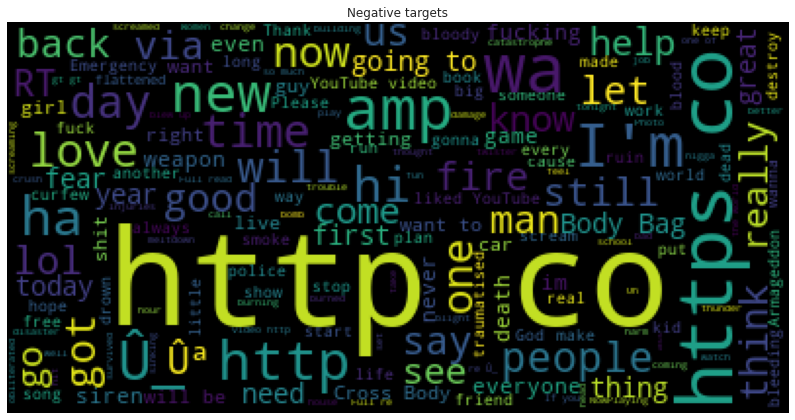

In [14]:
### Visualising for negative texts
negative = train.text[train.target == 0]
negative_texts = negative.tolist()
negative_texts_combined = ' '.join(negative_texts)
plt.figure(figsize=(14,14))
plt.imshow(WordCloud().generate(negative_texts_combined))
plt.axis("off")
plt.title("Negative targets")

In [15]:
#text = "model love u take u time urð\x9f\x93± ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91 ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦"
#print(text)
#text = remove_irrelevant(text)
#text = remove_punc(text)
#text = remove_emoji(text)
#text = re.sub('[@#]*[@\w]*\d{1,}[@\w]*','',text)
#text = re.sub('\d+','',text)
#text = re.sub('_*',' ',text)
#text = re.sub('[[\w*]]*','',text)
#text = re.sub('[\t\n\r\f\v]+','',text)
#text = re.sub('@\w*','',text)
#text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
#text = remove_punc(text)
#print("\n");print(text)
#print(text)

In [16]:
## example demonstrating decoding into ASCII characters

string_with_nonASCII = "àa string withé all the fuünny charactersß."

encoded_string = string_with_nonASCII.encode("ascii", "ignore")
decode_string = encoded_string.decode()

print(decode_string)

a string with all the funny characters.


In [17]:
## example demonstrating removal of unicode encoded characters

string = "jbj\x9f gn9 blasts"
print(string)

string_unicode_removed = string.encode("ascii", "ignore").decode()
print(string_unicode_removed)

jbj gn9 blasts
jbj gn9 blasts


In [18]:
def remove_irrelevant(text):
    
    ## convert non-ASCII to ASCII characters
    text = text.encode("ascii","ignore").decode()
    ## remove emails
    text = re.sub('[\w\.-]+@[\w\.-]+','',text)
    ## remove words within brackets
    text = re.sub('\[.*?\]', '', text)
    ## remove words containing nos. & special characters in between
    text = re.sub('[@#-]*[@\w]*\d{1,}[-@\w]*','',text)
    ## remove numbers
    text = re.sub('\d+','',text)
    ## remove blankspace characters
    text = re.sub('[\t\n\r\f\v]+','',text)
    ## remove callouts (starting with @)
    text = re.sub('@\w*','',text)
    ## remove urls
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    ## convert to lowercase
    text = text.lower()
    
    return text

### remove punctuations
def remove_punc(text):
    not_punc = [w for w in text if w not in string.punctuation]
    text_punc_removed = ''.join(not_punc)
    return text_punc_removed

def remove_emoji(text): ## remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)    
 
### remove repetitive characters in a word
def rep(text):
    grp = text.group(0)
    if len(grp) > 1:
        return grp[0:2] # can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert


### Lemmatization
def lemmatize(text):
    
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(i) for i in text.split()])

In [19]:
### example removal of irrelevant characters
import string
text = "fdf @nj23jnj-jn nkn! @ddsk kkm [sssd23_dd!]"

text = remove_irrelevant(text)
text = remove_punc(text)

print(text)

fdf  nkn  kkm 


In [20]:
### example showing conversion of repetitive characters to 2 characters
sentence="heyyy givvve meee the address"
unique_char(rep,sentence)

'heyy givve mee the address'

In [21]:
### cleaning the texts
train["text"] = train["text"].apply(lambda x:remove_irrelevant(x))
train["text"] = train["text"].apply(lambda x:remove_punc(x))
train["text"] = train["text"].apply(lambda x:remove_emoji(x))
train["text"] = train["text"].apply(lambda x:unique_char(rep,x))
train["text"] = train["text"].apply(lambda x:lemmatize(x))

positive = train.text[train.target == 1]
negative = train.text[train.target == 0]

train.head()

,id,text,target
0,1,our deed are the reason of this earthquake may...,1
1,4,forest fire near la ronge sask canada,1
2,5,all resident asked to shelter in place are bei...,1
3,6,people receive wildfire evacuation order in ca...,1
4,7,just got sent this photo from ruby alaska a sm...,1


In [22]:
### Visualising cleaned texts for identifying stopwords

words_combined = []
for i in range(train.shape[0]):
    for w in train.text[i].split():
        words_combined.append(w)
#words_combined
#print(len(words_combined))

dict = Counter(words_combined).most_common()
dict[:60]

[('the', 3255),
 ('a', 2503),
 ('in', 1973),
 ('to', 1944),
 ('of', 1826),
 ('and', 1412),
 ('i', 1382),
 ('is', 942),
 ('for', 893),
 ('on', 852),
 ('it', 834),
 ('you', 791),
 ('my', 673),
 ('with', 572),
 ('that', 560),
 ('at', 541),
 ('by', 523),
 ('this', 475),
 ('from', 418),
 ('be', 407),
 ('are', 402),
 ('wa', 392),
 ('have', 386),
 ('fire', 351),
 ('like', 346),
 ('up', 320),
 ('just', 318),
 ('so', 318),
 ('me', 314),
 ('but', 310),
 ('amp', 303),
 ('im', 301),
 ('not', 294),
 ('your', 292),
 ('out', 269),
 ('after', 259),
 ('will', 257),
 ('all', 256),
 ('ha', 255),
 ('when', 255),
 ('get', 254),
 ('no', 252),
 ('an', 251),
 ('u', 245),
 ('if', 241),
 ('he', 238),
 ('we', 237),
 ('new', 225),
 ('via', 220),
 ('now', 219),
 ('more', 217),
 ('about', 212),
 ('dont', 206),
 ('one', 203),
 ('or', 200),
 ('people', 198),
 ('what', 198),
 ('there', 195),
 ('they', 191),
 ('been', 191)]

In [23]:
## Adding more stopwords(unigram)

stopwords = stopwords.words("english")

add = [word for word,count in dict if count>200]+['ve','rs','ll','d','t','s']

keep = ['i','you','my','with','like','as','me','your','not','its','out','after','all','no','fire','we','get','new'
       ,'now','more','dont','about']

if add not in stopwords:
    stopwords_added = stopwords + add
stopwords_added  

stopwords_unigram = [w for w in stopwords_added if w not in keep]
print(stopwords_unigram)

['myself', 'our', 'ours', 'ourselves', "you're", "you've", "you'll", "you'd", 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'until', 'while', 'of', 'at', 'by', 'for', 'against', 'between', 'into', 'through', 'during', 'before', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'any', 'both', 'each', 'few', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'd', 'll', 'm', 'o', 're',

In [24]:
### demo showing to generate n-grams

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ')]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

generate_ngrams("ccc zxxc  asd asca  dvdd asfa",n_gram=2)## bigrams

['ccc zxxc', 'zxxc ', ' asd', 'asd asca', 'asca ', ' dvdd', 'dvdd asfa']

In [25]:
# Bigrams

disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in positive:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in negative:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in positive:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in negative:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

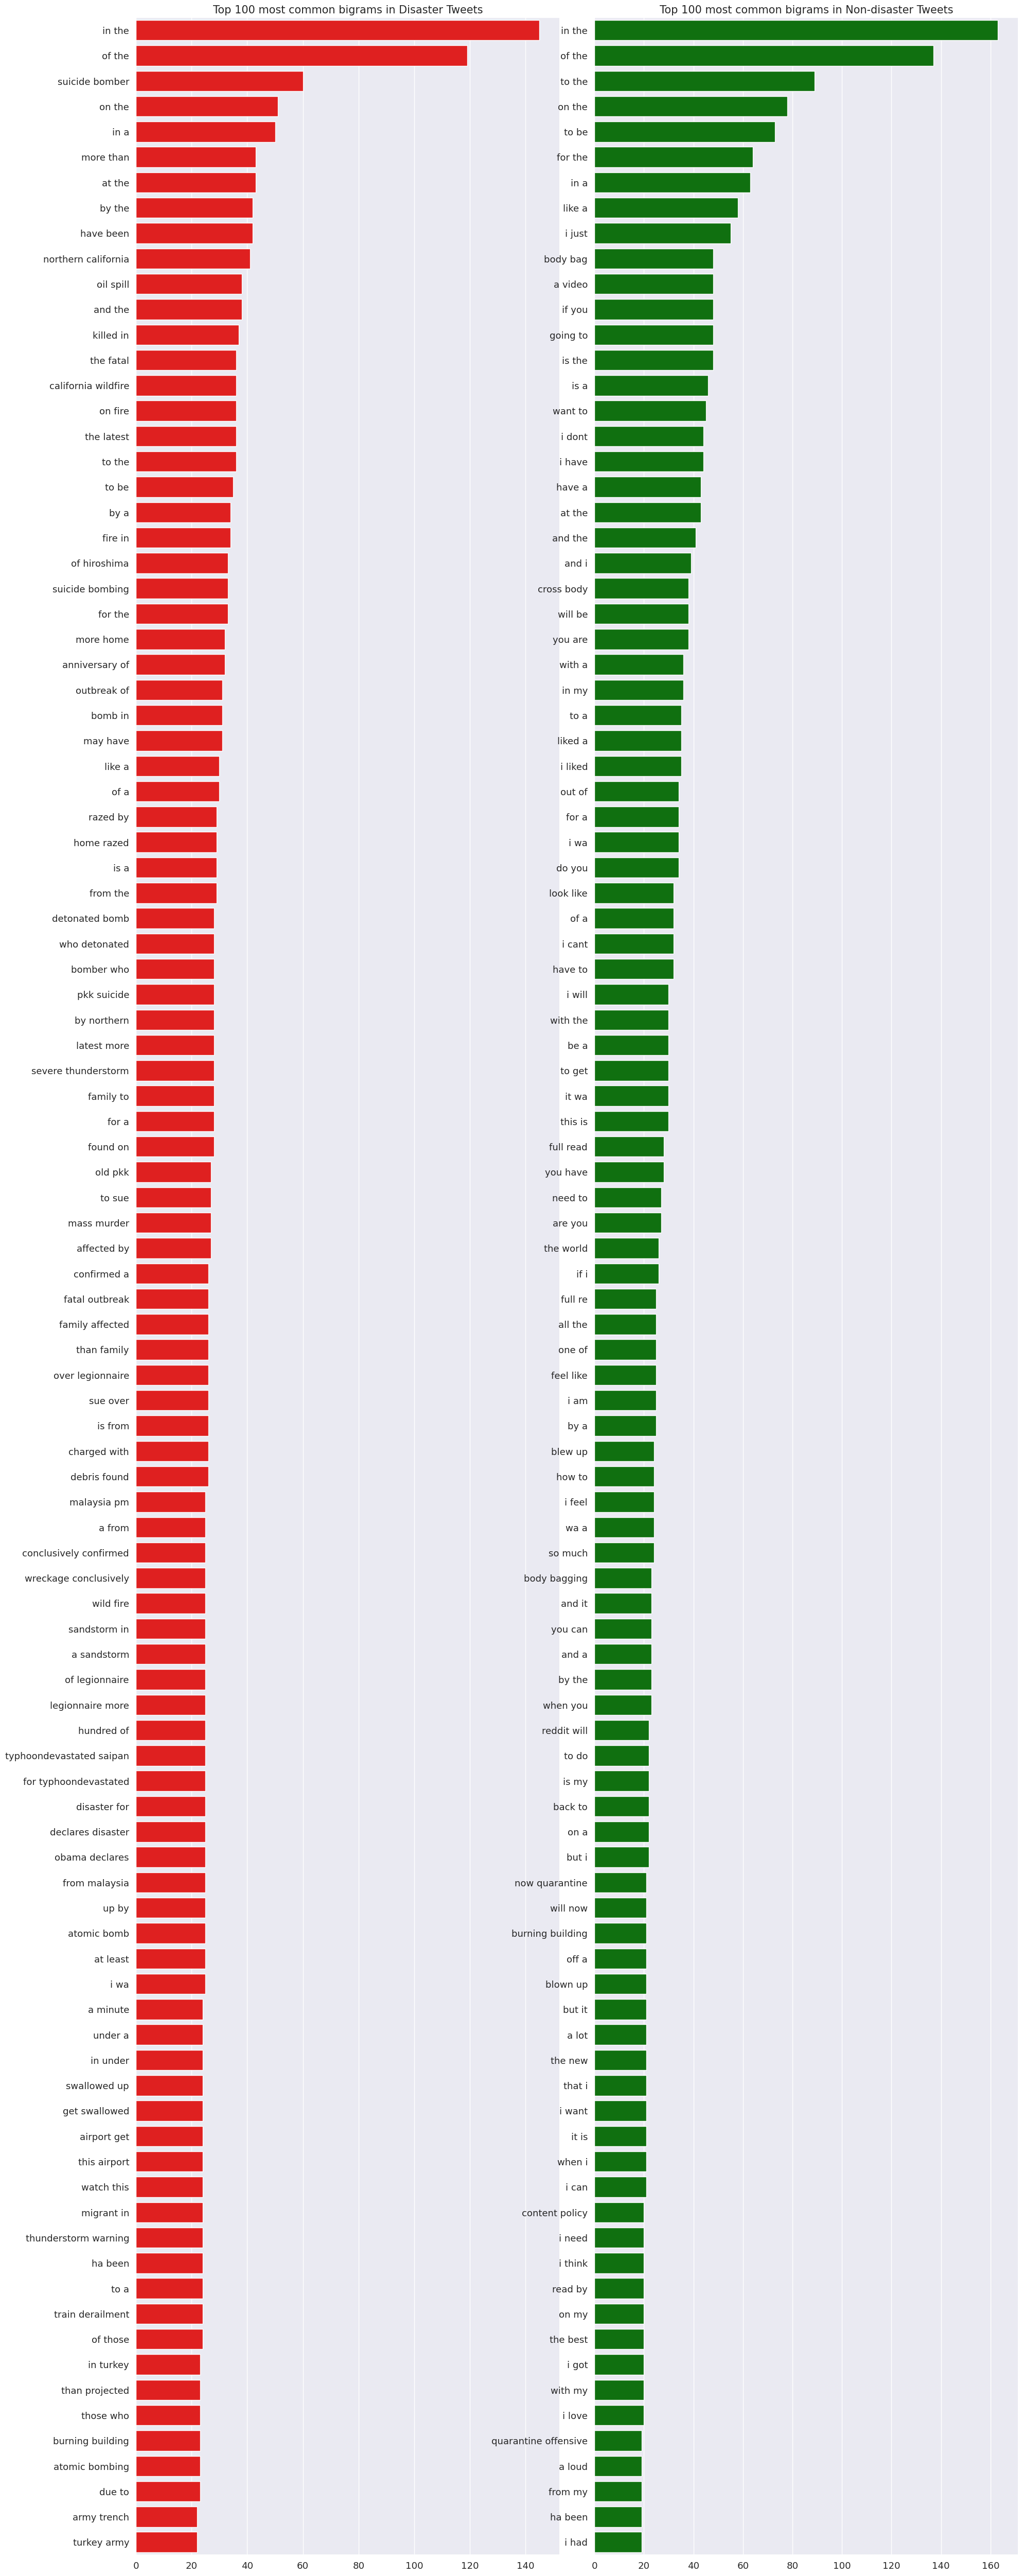

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:100], x=df_disaster_bigrams[1].values[:100], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:100], x=df_nondisaster_bigrams[1].values[:100], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

N = 100
axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [27]:
## adding bigram stopwords

add_bigrams_positive = ['in the','of the','on the','by the','at the','and the','to be','to the','by a','for the',
              'like a','of a','is a','from the','for a','as from','is from','for a','under a','in under','to a']

add_bigrams_negative = ['for a','i wa','do you','of a','have to',
                   'with the','be a','to get','it wa','are you','if i','full re','wa a']

stopwords_bigram = add_bigrams_positive + add_bigrams_negative
print(stopwords_bigram)

['in the', 'of the', 'on the', 'by the', 'at the', 'and the', 'to be', 'to the', 'by a', 'for the', 'like a', 'of a', 'is a', 'from the', 'for a', 'as from', 'is from', 'for a', 'under a', 'in under', 'to a', 'for a', 'i wa', 'do you', 'of a', 'have to', 'with the', 'be a', 'to get', 'it wa', 'are you', 'if i', 'full re', 'wa a']


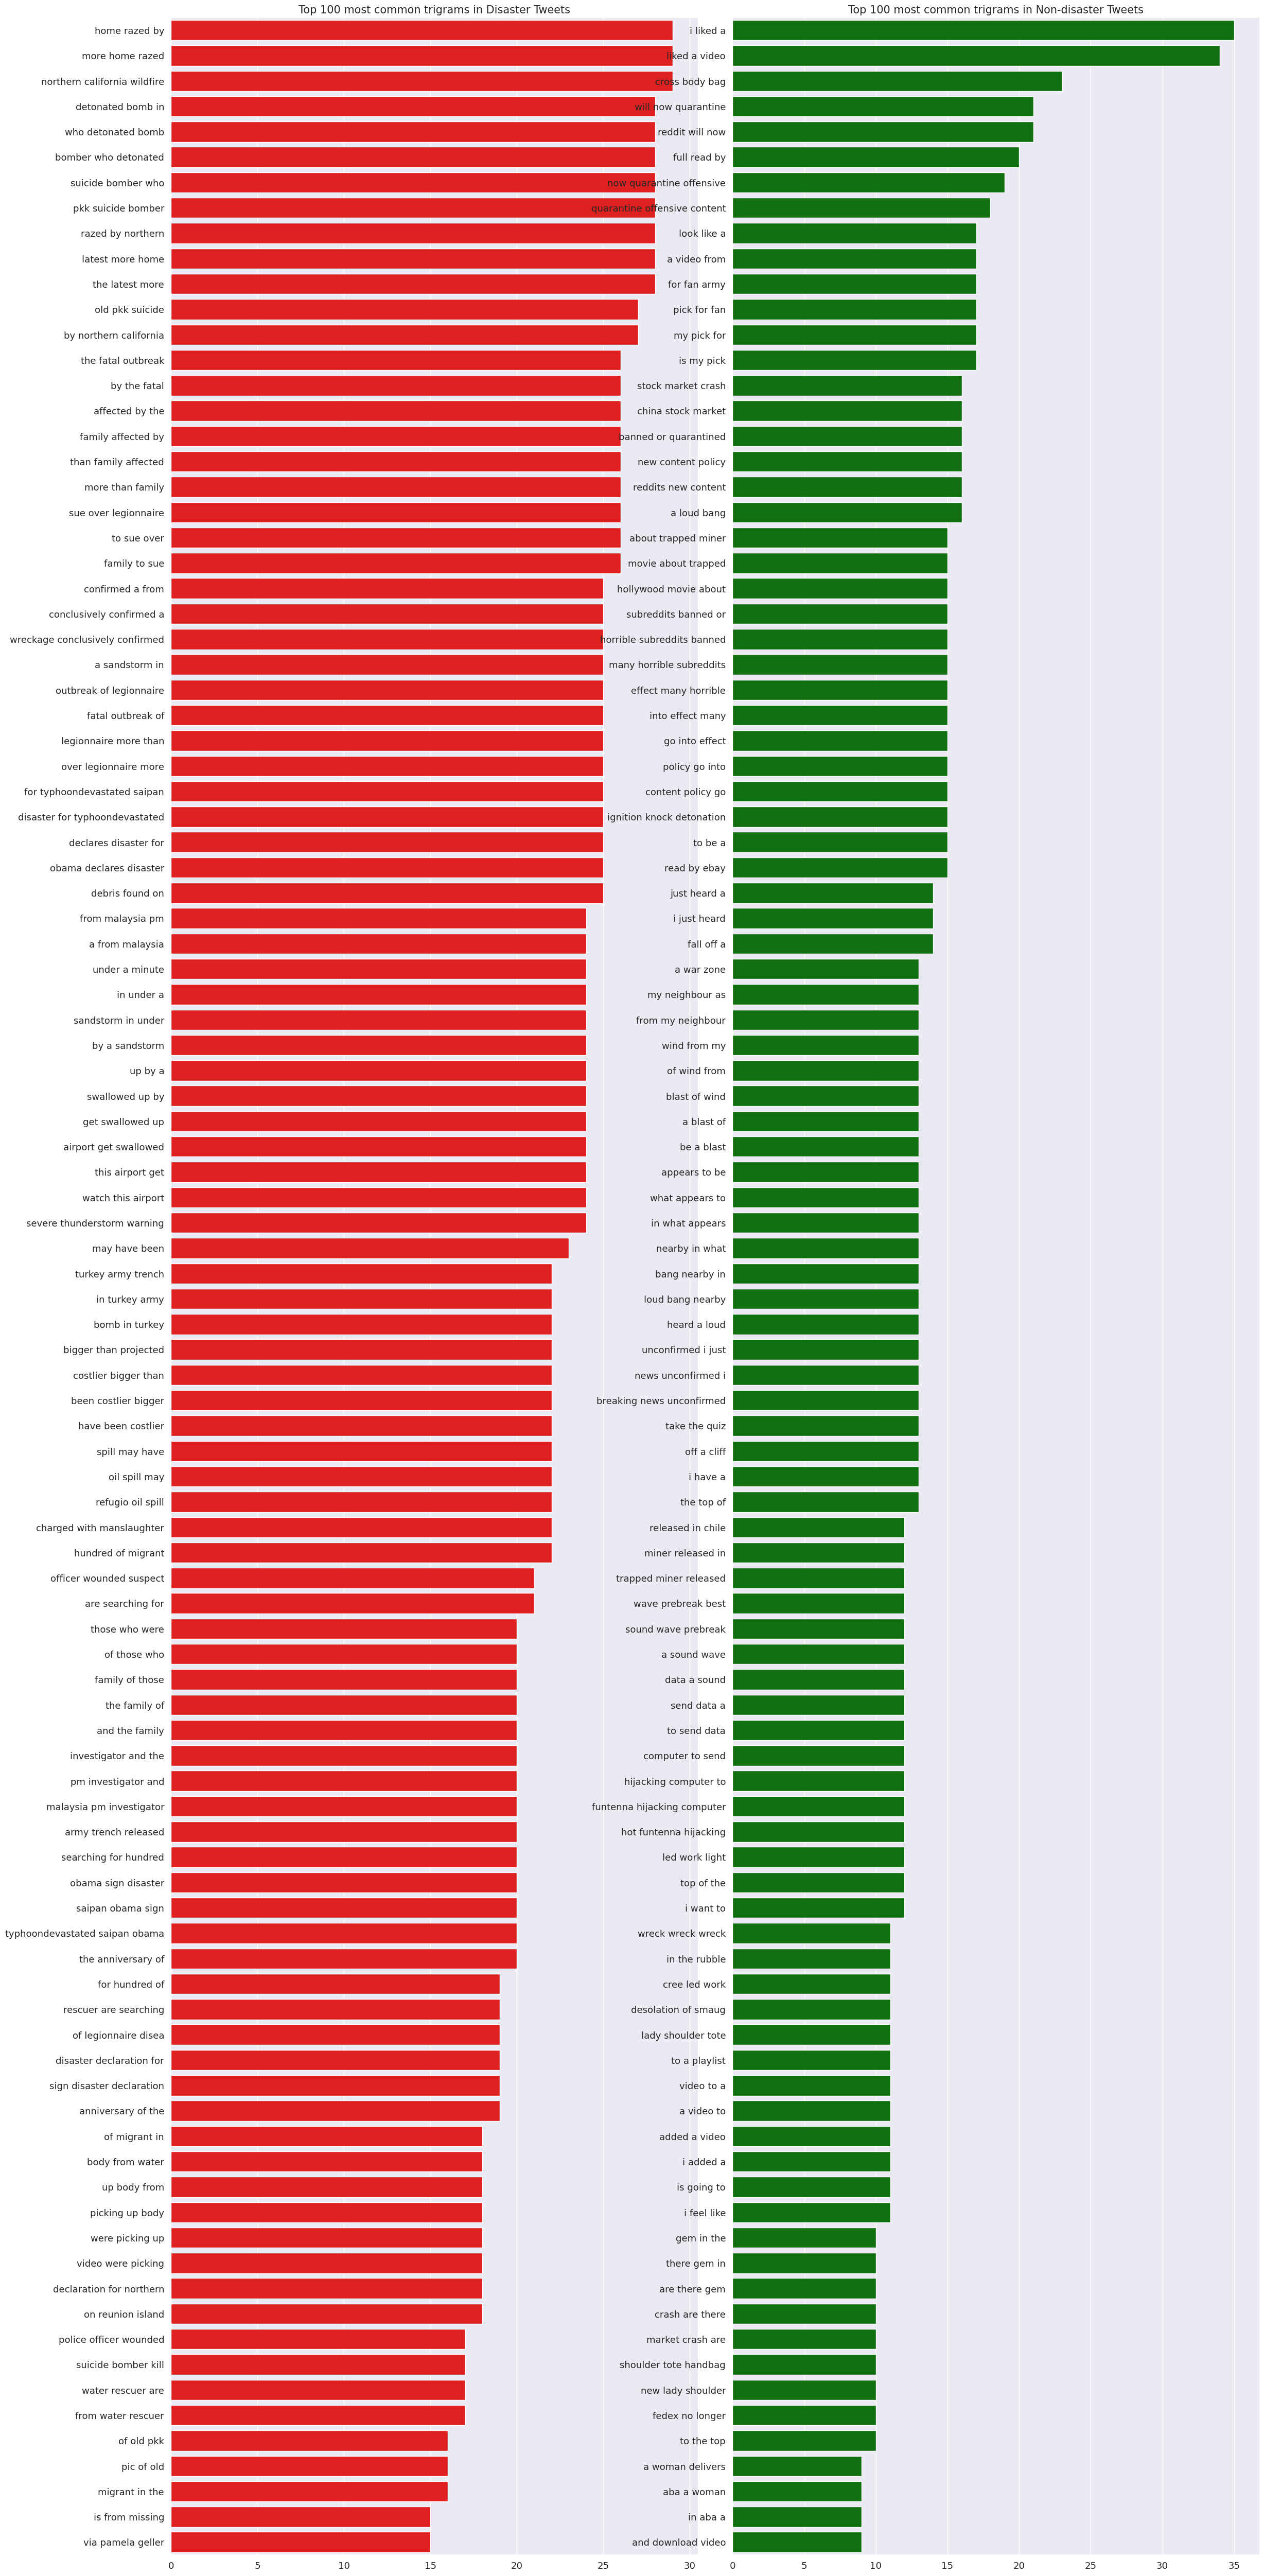

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(22, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_trigrams[0].values[:100], x=df_disaster_trigrams[1].values[:100], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:100], x=df_nondisaster_trigrams[1].values[:100], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

N = 100
axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [29]:
### adding trigram stopwords

add_trigrams_positive = ['in under a','up by a']
add_trigrams_negative = ['china stock market','cross body bag','reddit will now']

stopwords_trigram = add_trigrams_positive + add_trigrams_negative
print(stopwords_trigram)

['in under a', 'up by a', 'china stock market', 'cross body bag', 'reddit will now']


In [30]:
xtrain,xvalid,ytrain,yvalid = train_test_split(train.text.values, train.target.values, test_size=0.2, 
                                              random_state=22)
print(xtrain.shape)
print(xvalid.shape)

(6090,)
(1523,)


In [31]:
pd.DataFrame(xtrain).head()

,0
0,newberg upheaval jacque betz responds looking ...
1,one direction is my pick for fan army directio...
2,untangle yourself from requiring your partner ...
3,im a disaster
4,for maximum damage activate for oldtimey oblit...


In [32]:
stopwords = stopwords_unigram + stopwords_bigram + stopwords_trigram
ctv = CountVectorizer(stop_words=stopwords ,ngram_range=(1,3))

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['as', 'bag', 'body', 'china', 'cross', 'full', 'get', 'like', 'market', 'now', 'reddit', 'stock', 'with', 'you'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [33]:
# Fitting a simple Logistic Regression on Counts

clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict(xvalid_ctv)

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(clf.score(xtrain_ctv, ytrain)))
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(clf.score(xvalid_ctv, yvalid)))
print('F1-score of Logistic Regression is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of Logistic Regression classifier on training set: 0.98
Accuracy of Logistic Regression classifier on test set: 0.80
F1-score of Logistic Regression is: 0.74


array([[808,  85],
       [212, 418]])

In [34]:
tfv = TfidfVectorizer(min_df=2,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [35]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

print('Accuracy of Logistic Regression classifier(with tfidf) on training set: {:.2f}'
     .format(clf.score(xtrain_tfv, ytrain)))
print('Accuracy of Logistic Regression(with tfidf) classifier on test set: {:.2f}'
     .format(clf.score(xvalid_tfv, yvalid)))
print('F1-score of Logistic Regression is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of Logistic Regression classifier(with tfidf) on training set: 0.88
Accuracy of Logistic Regression(with tfidf) classifier on test set: 0.80
F1-score of Logistic Regression is: 0.73


array([[802,  91],
       [216, 414]])

Logistic regression works better with CountVectorizer than TfidfVectorizer

In [36]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

print('Accuracy of Naive Bayes classifier(with tfidf) on training set: {:.2f}'
     .format(clf.score(xtrain_tfv, ytrain)))
print('Accuracy of Naive Bayes classifier(with tfidf) classifier on validation set: {:.2f}'
     .format(clf.score(xvalid_tfv, yvalid)))
print('F1-score of Naive Bayes (with tf-idf) is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of Naive Bayes classifier(with tfidf) on training set: 0.87
Accuracy of Naive Bayes classifier(with tfidf) classifier on validation set: 0.79
F1-score of Naive Bayes (with tf-idf) is: 0.70


array([[822,  71],
       [255, 375]])

In [37]:
# Fitting a Naive Bayes on Counts

clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict(xvalid_ctv)

print('Accuracy of Naive Bayes classifier(with CountVectorizer) on training set: {:.2f}'
     .format(clf.score(xtrain_ctv, ytrain)))
print('Accuracy of Naive Bayes classifier(with CountVectorizer) on test set: {:.2f}'
     .format(clf.score(xvalid_ctv, yvalid)))
print('F1-score of Naive Bayes is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of Naive Bayes classifier(with CountVectorizer) on training set: 0.97
Accuracy of Naive Bayes classifier(with CountVectorizer) on test set: 0.78
F1-score of Naive Bayes is: 0.73


array([[719, 174],
       [164, 466]])

As we noted ,the performance doesnot  improves with Naive Bayes.
Now lets check the performance of SVM.

Since SVM's take a lot of time to run, so we will reduce the no. of features using Singular Value Decomposition.
Also we have to perform Feature Scaling before applying SVM.

In [38]:
### There are more than 1lakh features obtained after CountVectorising
### We need to reduce it to make SVM run efficiently
svd = TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [39]:
# Fitting a simple SVM( with tf-idf values)
clf = SVC(C=1.0) 
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict(xvalid_svd_scl)

print('Accuracy of SVC classifier(with TfidfVectorizer) on training set: {:.2f}'
     .format(clf.score(xtrain_svd_scl, ytrain)))
print('Accuracy of SVC classifier(with TfidfVectorizer) on test set: {:.2f}'
     .format(clf.score(xvalid_svd_scl, yvalid)))
print('F1-score of SVC classifier is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of SVC classifier(with TfidfVectorizer) on training set: 0.82
Accuracy of SVC classifier(with TfidfVectorizer) on test set: 0.78
F1-score of SVC classifier is: 0.69


array([[800,  93],
       [249, 381]])

In [40]:
#### Fitting a simple SVM( with CountVectorizer fit)

svd.fit(xtrain_ctv)
xtrain_svd = svd.transform(xtrain_ctv)
xvalid_svd = svd.transform(xvalid_ctv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

clf = SVC(C=1.0) 
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict(xvalid_svd_scl)

print('Accuracy of SVC classifier(with CountVectorizer) on training set: {:.2f}'
     .format(clf.score(xtrain_svd_scl, ytrain)))
print('Accuracy of SVC classifier(with CountVectorizer) on test set: {:.2f}'
     .format(clf.score(xvalid_svd_scl, yvalid)))
print('F1-score of SVC classifier(over counts) is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of SVC classifier(with CountVectorizer) on training set: 0.82
Accuracy of SVC classifier(with CountVectorizer) on test set: 0.77
F1-score of SVC classifier(over counts) is: 0.67


array([[811,  82],
       [270, 360]])

Looks like Svm didnot work well here. 
Lets apply the xgboost

In [41]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict(xvalid_tfv.tocsc())

print('Accuracy of XGB classifier(with TfidfVectorizer) on training set: {:.2f}'
     .format(clf.score(xtrain_tfv.tocsc(), ytrain)))
print('Accuracy of XGB classifier(with TfidfVectorizer) on test set: {:.2f}'
     .format(clf.score(xvalid_tfv.tocsc(), yvalid)))
print('F1-score of XGB classifier is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of XGB classifier(with TfidfVectorizer) on training set: 0.84
Accuracy of XGB classifier(with TfidfVectorizer) on test set: 0.77
F1-score of XGB classifier is: 0.69


array([[791, 102],
       [245, 385]])

In [42]:
# Fitting a simple xgboost on Counts
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict(xvalid_ctv.tocsc())

print('Accuracy of XGB classifier(with TfidfVectorizer) on training set: {:.2f}'
     .format(clf.score(xtrain_ctv.tocsc(), ytrain)))
print('Accuracy of XGB classifier(with TfidfVectorizer) on test set: {:.2f}'
     .format(clf.score(xvalid_ctv.tocsc(), yvalid)))
print('F1-score of XGB classifier is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of XGB classifier(with TfidfVectorizer) on training set: 0.83
Accuracy of XGB classifier(with TfidfVectorizer) on test set: 0.79
F1-score of XGB classifier is: 0.71


array([[795,  98],
       [228, 402]])

In [43]:
### parameter(C) tuning using Grid Search for Logistic regression over counts

gsc = GridSearchCV(estimator=LogisticRegression(max_iter=1000), 
                  param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]},
                  cv=5, scoring='f1')

grid_result = gsc.fit(xtrain_ctv, ytrain)
best_params = grid_result.best_params_
best_params

{'C': 1}

So C=1 is the optimal value for logit model over counts. Lets turn to Naive Bayes model. 

In [44]:
### parameter(C) tuning using Grid Search for NaiveBayes over counts

gsc = GridSearchCV(estimator=MultinomialNB(), 
                  param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
                  cv=5, scoring='f1')

grid_result = gsc.fit(xtrain_ctv, ytrain)
best_params = grid_result.best_params_
best_params

{'alpha': 1}

Lets experiment with the SVD components ,after then grid search for logit model parameters

In [45]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression(max_iter=1000)

# Create the pipeline 
clf = Pipeline([('svd', svd),
                         ('scl', scl),('lr',lr_model)])

In [46]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [47]:
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1',
                     verbose=10, n_jobs=-1, iid=True, refit=True, cv=5)

result = model.fit(xtrain_ctv, ytrain)
best_params = result.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [48]:
# hence the best fit happens with 180 svd components
best_params

{'lr__C': 0.1, 'lr__penalty': 'l2', 'svd__n_components': 180}

In [49]:
svd = TruncatedSVD(n_components=180)
svd.fit(xtrain_ctv)
xtrain_svd = svd.transform(xtrain_ctv)
xvalid_svd = svd.transform(xvalid_ctv)

clf = LogisticRegression(C=1.0, max_iter=1000, penalty='l2')
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict(xvalid_svd)

print('Accuracy of Logistic Regression classifier(with counts) on training set: {:.2f}'
     .format(clf.score(xtrain_svd, ytrain)))
print('Accuracy of Logistic Regression(with counts) classifier on test set: {:.2f}'
     .format(clf.score(xvalid_svd, yvalid)))
print('F1-score of Logistic Regression is: {:.2f}'.format(f1_score(yvalid,predictions)))
cm = confusion_matrix(yvalid, predictions)
cm

Accuracy of Logistic Regression classifier(with counts) on training set: 0.80
Accuracy of Logistic Regression(with counts) classifier on test set: 0.79
F1-score of Logistic Regression is: 0.71


array([[800,  93],
       [228, 402]])

Application of SVD for logit model is worthless.

In [50]:
# Model tuning a RandomForestClassifier with 180 SVD components

gsc = GridSearchCV(estimator=RandomForestClassifier(), 
                  param_grid = {'n_estimators': [10, 100, 200]},
                  cv=5, scoring='f1')

grid_result = gsc.fit(xtrain_svd, ytrain)
best_params = grid_result.best_params_
best_params

{'n_estimators': 100}

In [51]:
# Fitting the RandomForest classifier with 180 svd components (over counts)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict(xvalid_svd)
print('F1-score of RandomForest is: {:.2f}'.format(f1_score(yvalid,predictions)))

F1-score of RandomForest is: 0.69


In [52]:
# Model tuning a RidgeClassifier with 180 SVD components

gsc = GridSearchCV(estimator=RidgeClassifier(), 
                  param_grid = {'alpha': [0.01, 0.1, 1, 10, 50, 100]},
                  cv=5, scoring='f1')

grid_result = gsc.fit(xtrain_ctv, ytrain)
best_params = grid_result.best_params_
best_params

{'alpha': 10}

In [53]:
clf = RidgeClassifier(alpha=10)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict(xvalid_ctv)

print('Accuracy of Ridge Regression classifier(with counts) on training set: {:.2f}'
     .format(clf.score(xtrain_ctv, ytrain)))
print('Accuracy of Ridge Regression classifier(with counts) classifier on test set: {:.2f}'
     .format(clf.score(xvalid_ctv, yvalid)))
print('F1-score of Ridge Regression is: {:.2f}'.format(f1_score(yvalid,predictions)))

Accuracy of Ridge Regression classifier(with counts) on training set: 0.98
Accuracy of Ridge Regression classifier(with counts) classifier on test set: 0.81
F1-score of Ridge Regression is: 0.74


In [54]:
### cleaning the test texts
test["text"] = test["text"].apply(lambda x:remove_irrelevant(x))
test["text"] = test["text"].apply(lambda x:remove_punc(x))
test["text"] = test["text"].apply(lambda x:remove_emoji(x))
test["text"] = test["text"].apply(lambda x:unique_char(rep,x))
test["text"] = test["text"].apply(lambda x:lemmatize(x))


In [55]:
my_final_submission = pd.DataFrame({'id':test.id.values, 'text':test.text.values})

In [56]:
my_final_submission.head()

,id,text
0,0,just happened a terrible car crash
1,2,heard about earthquake is different city stay ...
2,3,there is a forest fire at spot pond goose are ...
3,9,apocalypse lighting spokane wildfire
4,11,typhoon soudelor kill in china and taiwan


In [57]:
clf = LogisticRegression(max_iter=1000, C=1.0)
clf.fit(xtrain_ctv, ytrain)

LogisticRegression(max_iter=1000)

In [58]:
xtest_ctv =  ctv.transform(my_final_submission.text.values)
my_final_submission["target"] = clf.predict(xtest_ctv)
my_final_submission.drop(columns=['text'], inplace=True)
my_final_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [59]:
my_final_submission.to_csv("submission.csv", index=False)